# Time Series Analysis
In this notebook, we will create a trading strategy using the ARIMA model on a Bank of America Time Series.

## Importing libraries 
Importing the relevant libraries for coding the strategy based on the ARIMA model. Numpy library will help us with quick vectorized calculations.Pandas is used for taking advantage of its powerful dataframes and matplotlib.pyplot is used to plot the price time series as well as the cumulative returns of the strategy. We will also import the adfuller function from the statsmodels.tsa.stattools to check if the time series is stationary. For the statistical analysis, we will import the ARIMA function from the statsmodels.tsa.arima_model to perform an ARIMA model and the functions plot_acf and plot_pacf from the library statsmodels.graphics.tsaplots to check for autocorrelation and partial autocorrelation behaviors on the time series. The library yfinance will be used to download intraday stock data. And the pyfolio for performing a quick backtest on the strategy returns.  

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

# Import adfuller
from statsmodels.tsa.stattools import adfuller

# For statistical analysis
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.dates as mdates # this is for formatting the dates 

import yfinance as yf
import pyfolio as pf


# Import libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt


## Fetch the working data
We will download the data from yahoo finance. The ticker for Bank of America is "BAC" and we will use intraday data from the whole year 2020.

In [2]:
df = yf.download( "BAC", start = "2020-01-01", end = "2020-12-31")[['Adj Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2020-01-02,34.709141
2020-01-03,33.988472
2020-01-06,33.939774
2020-01-07,33.715782
2020-01-08,34.056641


### Check if the data has any missing values. 

In [3]:
null_values = int( df.isnull().sum() )

print(f"There are {null_values} missing values on BAC asset" )

There are 0 missing values on BAC asset


### Check if the time series is stationary 
We will use the augmented dicker-fuller test which is a test for checking stationarity. The test makes the assumption that there is a unit-root in the univariate process in the presence of serial correlation. In simple terms, the null hypothesis will be that the series given is not stationary. Thus, the alternative hypothesis is the series is stationary. If we can reject the null hypothesis in favor of the alternative hypothesis( meaning the p-value is less than 0.05). We can conclude that the time series is indeed stationary. 

Since we will perform this stationarity test several times, we define a function for performing that task. 

In [4]:
def check_for_stationarity(df, name):
    '''
    Check if a time series with its respected ticker name is stationary or not. 
    Takes in as input dataframe object df and a string datetype name and prints 
    whether or not the time series is stationary
    '''
    adf_test = adfuller(df)  # perform an augmented dicker-fuller test for checking stationarity.
    
    if ( adf_test[1] < 0.05 ): # the p-value is less than 0.05, which means reject the null hypothesis in favor of the
                            # alternative hypothesis.
        print(f"The time series for {name} is stationary")
    else:
        print(f"The time series for {name} is Not stationary")

### Plotting the time series
We might be able to identify if the time series is Not stationary. If we notice that any statistical property is changing throughout time such as its mean or variance ,then we can make the assumption that is not stationary.  

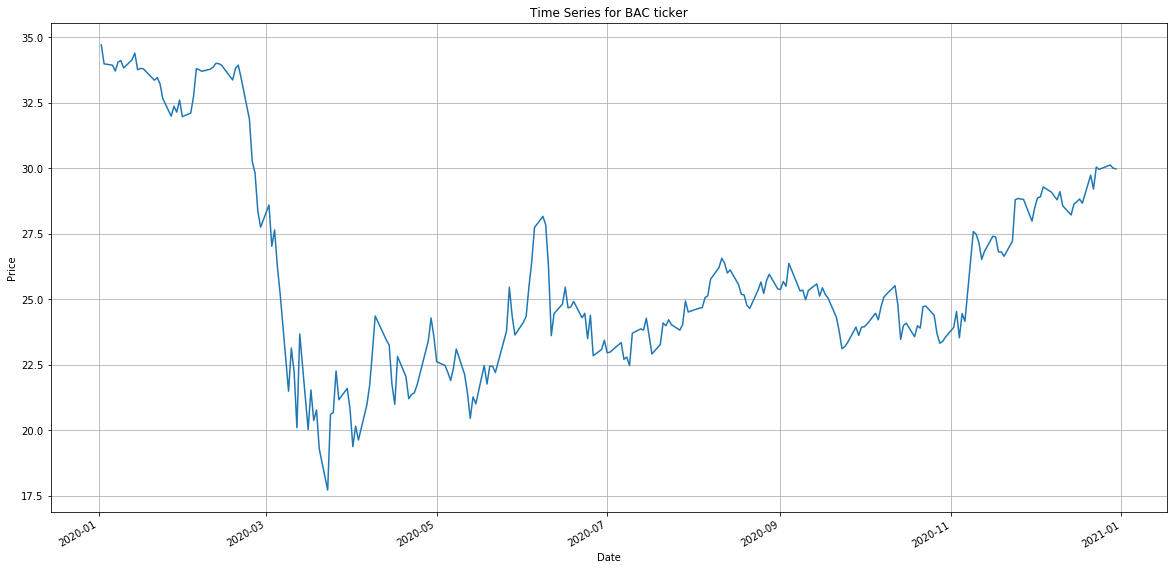

In [5]:
df['Adj Close'].plot(figsize = (20,10), grid = True, title = "Time Series for BAC ticker") 
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

From the plot the time series looks not stationary ,but let's confirm that assumption by applying the adf test.

In [6]:
check_for_stationarity(df, 'BAC')

The time series for BAC is Not stationary


### Convert the non-stationary time series to a stationary time series
Our assumption was correct. The time series is not stationary. We need to convert it to a stationary time series before we can apply the ARMA model. One simple way to achieve this is by differencing. In differencing, we just subtract the previous price from the current price.

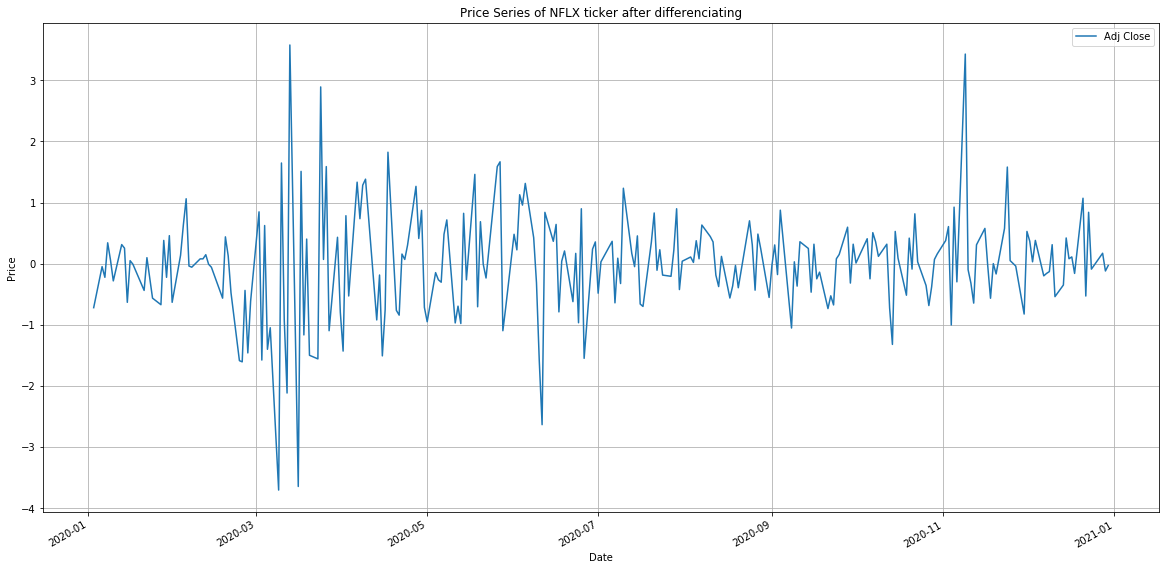

In [7]:
df.diff().dropna().plot( figsize = (20,10), grid = True, title = "Price Series of NFLX ticker after differenciating" ) 
plt.ylabel("Price")
plt.xlabel( "Date" )
plt.show()

From the plot the time series after differencing looks stationary ,but let's confirm that assumption by applying the adf test.

In [8]:
check_for_stationarity( df.diff().dropna(), "BAC_differentiated"  )

The time series for BAC_differentiated is stationary


Since it required only one differenciation to make the time series stationarity. We can use 1 as an order of i. Meaning that for our ARIMA model will have ARIMA(p,1,q) where 1 is the order of the integrated term. 

### Find the order of AR and MA
Now we need to find the values for the parameters p and q. To do that we need to look at the partial autocorrelation and autocorrelation and check if there is any statistically significant lag. 

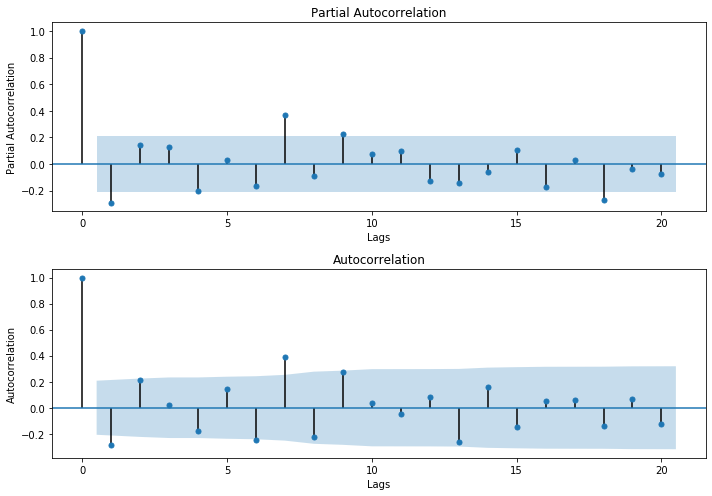

In [9]:
# Find the order of AR and MA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

rolling_window = 90    # we are going to use 90 days data
# Plot Partial Autocorrelation Function
plot_pacf(df['Adj Close'][:rolling_window].diff().dropna(), lags=20, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial Autocorrelation')

# Plot Autocorrelation Function
plot_acf(df['Adj Close'][:rolling_window].diff().dropna(), lags=20, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

From the plot above, we can see that there is a statistically significant lag at the first and seventh lag. After the seventh lag, all of the lags are statistically insignificant for both the ACF and PACF. 

Therefore, some good choices as ARIMA model are:
               
   * ARIMA( p=1, d= 1, q= 1)  
   * ARIMA( p=7, d= 1, q= 1)

We know that as we go farthest the lag term there would be an increase on the parameters needed to be estimated on the ARMA model.Therefore, an increase in the complexity of the model resulting in overfitting. We want to avoid overfitting and therefore choose the first model. 

### Model ARIMA(1,1,1) 

In [10]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Fit ARIMA model
model = ARIMA(df['Adj Close'][:rolling_window], order=(1, 1, 1))
model_fit_0 = model.fit()
print(model_fit_0.params.round(2)) #let's look at the parameters

const               -0.14
ar.L1.D.Adj Close   -0.48
ma.L1.D.Adj Close    0.20
dtype: float64


From the output above, we can see that the model becomes
$$ ARIMA(1,1,1) = y_t = -0.14 - 0.48y'_{t-1} + 0.20\epsilon_{t-1} + \epsilon_t$$

### Forecast the time series
We defined a function to predict the price of 1 day

In [11]:
def predict_price_ARIMA(train_data):
    '''
    This function takes as iput a dataframe train_data and performs
    an Arima model to make a predict on the price
    '''
    # Define model
    model = ARIMA(train_data, order=(1, 1, 1))
    
    # Fit the model
    try:
        model_fit = model.fit(disp=0, start_params = model_fit_0.params )
        # Make the forecast and return the prediction price
        return model_fit.forecast()[0][0]
    except:# something went wrong and we couldn't fit the model and make the price prediction
        pass

In [12]:
# Predict the price using `predict_price_ARIMA` function
df['predicted_price'] = df['Adj Close'].rolling(rolling_window).apply(predict_price_ARIMA)

# Shift the predicted price by 1 period since this is a prediction for the next day
df['predicted_price'] = df['predicted_price'].shift(1)

<a id='evaluate'></a> 
## Evaluate model performance

You can check the performance of the model by calculating the error metrics and residual analysis.

In [19]:
def model_performance(observed, predicted):
    """
    This function takes as input two dataframes called observed and predicted prices.
    It calculates and prints the Mean Absolute Error, Mean Squared Error,
    Root Mean Squared Error and Mean Absolute Percentage Error by comparing the actual
    or observed price with our prediction price. Also, plots the predicted vs observed 
    prices, the residuals and performs an autocorrelation of the residuals. 
    """
    
    # Mean Absolute Error
    mae = mean_absolute_error(observed, predicted)
    print('The Mean Absolute Error is %.2f' % mae)

    # Mean Squared Error
    mse = mean_squared_error(observed, predicted)
    print('The Mean Squared Error is %.2f' % mse)

    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(observed, predicted))
    print('The Root Mean Squared Error is %.2f' % rmse)

    # Mean Absolute Percentage Error
    mape = 100 * ((observed-predicted)/observed).abs().mean()
    print('The Mean Absolute Percentage Error is %.2f' % mape)

    # Residuals
    residuals = observed - predicted
    labels = observed.index
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11)) # set 3 subplots
    
    # Plot the predicted and observed price
    observed.plot(ax=ax1, color='purple')
    predicted.plot(ax=ax1, color='green')
    ax1.set_ylabel('Price')
    ax1.set_title('Predicted Vs. Observed')
    
    # Plot the residuals
    ax2.fill_between(residuals.index, residuals.values, color='red')
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Date')
    ax2.set_title('Residuals')
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
    _= plt.xticks(rotation=45)
    
    # Autocorrelation plot of residuals
    plot_acf(residuals, ax=ax3, color='blue')
    ax3.set_xlabel('Lags')
    ax3.set_ylabel('Autocorrelation')
    ax3.set_title('Autocorrelation of Residuals')

    plt.tight_layout()
    plt.show()

The Mean Absolute Error is 0.50
The Mean Squared Error is 0.49
The Root Mean Squared Error is 0.70
The Mean Absolute Percentage Error is 1.98


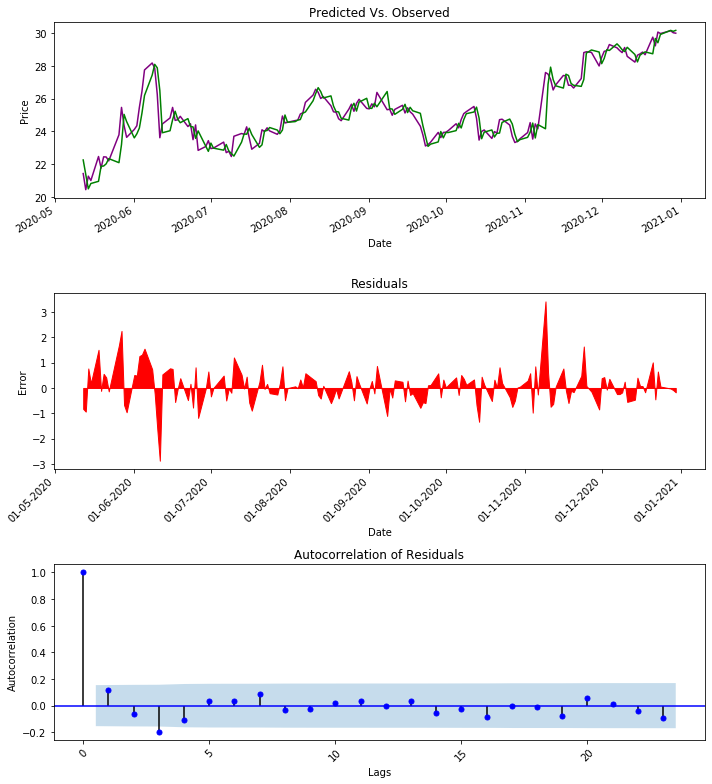

In [20]:
# call the model_performance function and see the model's performance
model_performance(df['Adj Close'].iloc[rolling_window:],
                  df['predicted_price'].iloc[rolling_window:])

From the above output we can conclude that:
  
  * The types of error calculations or error metrics are low. That's a good sign since the purpose of the model is to minimize those errors and staying as close as possible to the actual values. We can even confirm that from the plot predicted vs observed. 
  * The residual plot looks like white noise since the plot looks like it is stationary. We know that white noise althought is completely random, it still has constant mean and constant variance. 
  * However, when we take a look at the autocorrelation plot, we can see that there is still some autocorrelation at lag 3 which indicates that our model can be improved. 

### Develop the strategy based on the ARIMA(1,1,1) 
From the ARIMA model we generated prediction on the stock prices.Then, we can generate trading signals from those predictions.
The strategy is simple if there was an increase on our prediction prices then go long otherwise we go short.

In [21]:
# Create trading signal
df['signal'] = np.where(df.predicted_price.shift(1) <
                          df.predicted_price, 1, -1) # if there was an increase on the predicted price 
                                                   # go long otherwise go short. 

# calculate the returns
df['returns'] = df['Adj Close'].pct_change()

# Get the returns of our strategy
df['strategy_returns'] = df.signal.shift(1)*df.iloc[rolling_window:].returns

## Analyze the Strategy Performance
We will define a function that will calculate the sharpe ratio of the strategy, the cumulative returns of the strategy, and the max drawdowns of the strategy. Also, plot the cumulative returns and the drawdowns of the strategy.

In [22]:
def analyse_strategy(strategy_returns):    
    
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

    # Cumulative Returns
    cumulative_returns = (strategy_returns+1).cumprod()
    
    # ---------- Drawdown calculations -------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = 100*((cumulative_returns)/running_max - 1)

    # Calculate the maximum drawdown
    max_dd = drawdown.min()

    # Print the statistics
    print('The Sharpe Ratio is %.2f' % sharpe_ratio)
    print('The cumulative return is %.2f' % (
      ((cumulative_returns[-1])-1)*100) + "%") 
    print("The maximum drawdown is %.2f" % max_dd + "%")

    # Plot
    labels = strategy_returns.index
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

    # Plot strategy returns
    ax1.plot(cumulative_returns, color='b')
    ax1.set_title('Cumulative Returns', fontsize=14)
    ax1.set_ylabel('Cumulative Returns', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
   
    # Plot max DD
    ax2.plot(drawdown, color='red')
    # Fill in-between the drawdown
    ax2.fill_between(drawdown.index, drawdown.values, color='red')
    ax2.set_title('Strategy Drawdown', fontsize=14)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))

    plt.tight_layout()
    plt.show()
    

The Sharpe Ratio is 0.86
The cumulative return is 20.00%
The maximum drawdown is -20.50%


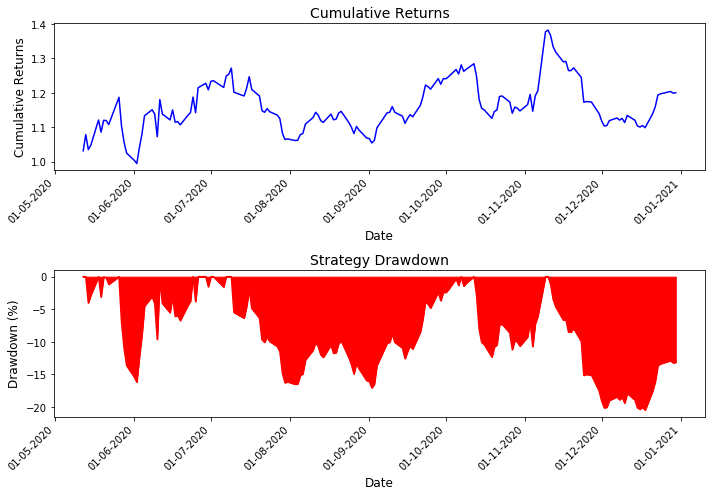

In [23]:
analyse_strategy(df['strategy_returns'].iloc[rolling_window:]) 

Start date,2020-01-02
End date,2020-12-30
Total months,12
,Backtest
Annual return,20.0%
Cumulative returns,20.0%
Annual volatility,43.7%
Sharpe ratio,0.86
Calmar ratio,0.98
Stability,0.13
Max drawdown,-20.5%


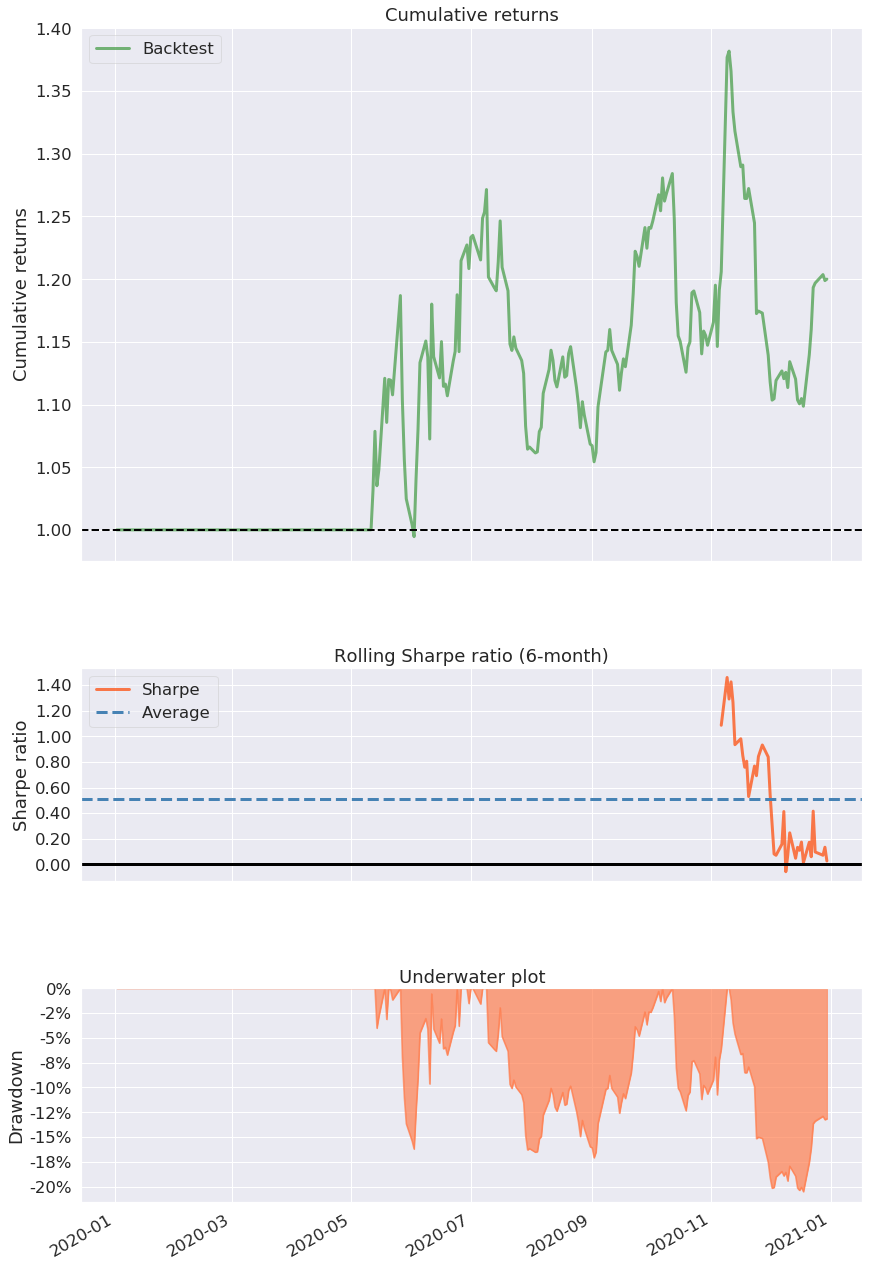

In [24]:
# Analyse results with pyfolio by passing the daily returns
pf.create_simple_tear_sheet( df['strategy_returns']) 